# Predicting Resale Ticket Margins - Utah Jazz StubHub Data
### By Joshua Singer, Karl Applegarth, and Alex Humble


### Final Project
The final project is your opportunity to do your own data project end to end and present the results to some local companies.

* Rubric
* Code Quality - 20%
* Describing, cleaning, and visualizing data - 25%
* Modeling - 25%
* Presentation / Storytelling - 30%

### Read in Data and Import Modules

In [1]:
# ##############
#Data Manipulation
import pandas as pd
import numpy as np
import math
from pandas import isnull


#Data Management
from zipfile import ZipFile
import glob
import os
import csv
import io
import json 
import uuid
import datetime
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Data Cleaning
import missingno as msno
import collections


In [3]:
#Import data 
dftot = pd.read_csv("/Users/alexhumble/Desktop/master_data_frame_tickets.csv",
                   low_memory =False)

In [4]:
dftot.head()

,amount,currentPrice,deliveryMethodList,deliveryMethodList2,deliveryMethodList3,deliveryMethodList4,deliveryMethodList5,deliveryTypeList,deliveryTypeList2,dirtyTicketInd,...,WinPercent,InclimateWeather,NightGame,Merge,Price,Straight View,Behind Basket View,Diagonal View,Unnamed: 61,Unnamed: 62
0,104.50,"{'amount': 104.5, 'currency': 'USD'}",17,22,23,25,0,4,5,0,...,0.43,0,0,109s21r,6.0,0,0,1,s,r
1,104.50,"{'amount': 104.5, 'currency': 'USD'}",17,22,23,25,0,4,5,0,...,0.43,0,0,109s21r,6.0,0,0,1,s,r
2,104.50,"{'amount': 104.5, 'currency': 'USD'}",17,22,23,25,0,4,5,0,...,0.43,0,0,109s21r,6.0,0,0,1,s,r
3,104.50,"{'amount': 104.5, 'currency': 'USD'}",17,22,23,25,0,4,5,0,...,0.43,0,0,109s21r,6.0,0,0,1,s,r
4,111.69,"{'amount': 111.69, 'currency': 'USD'}",43,0,0,0,0,10,0,0,...,0.43,0,0,123s19r,6.0,0,1,0,s,r


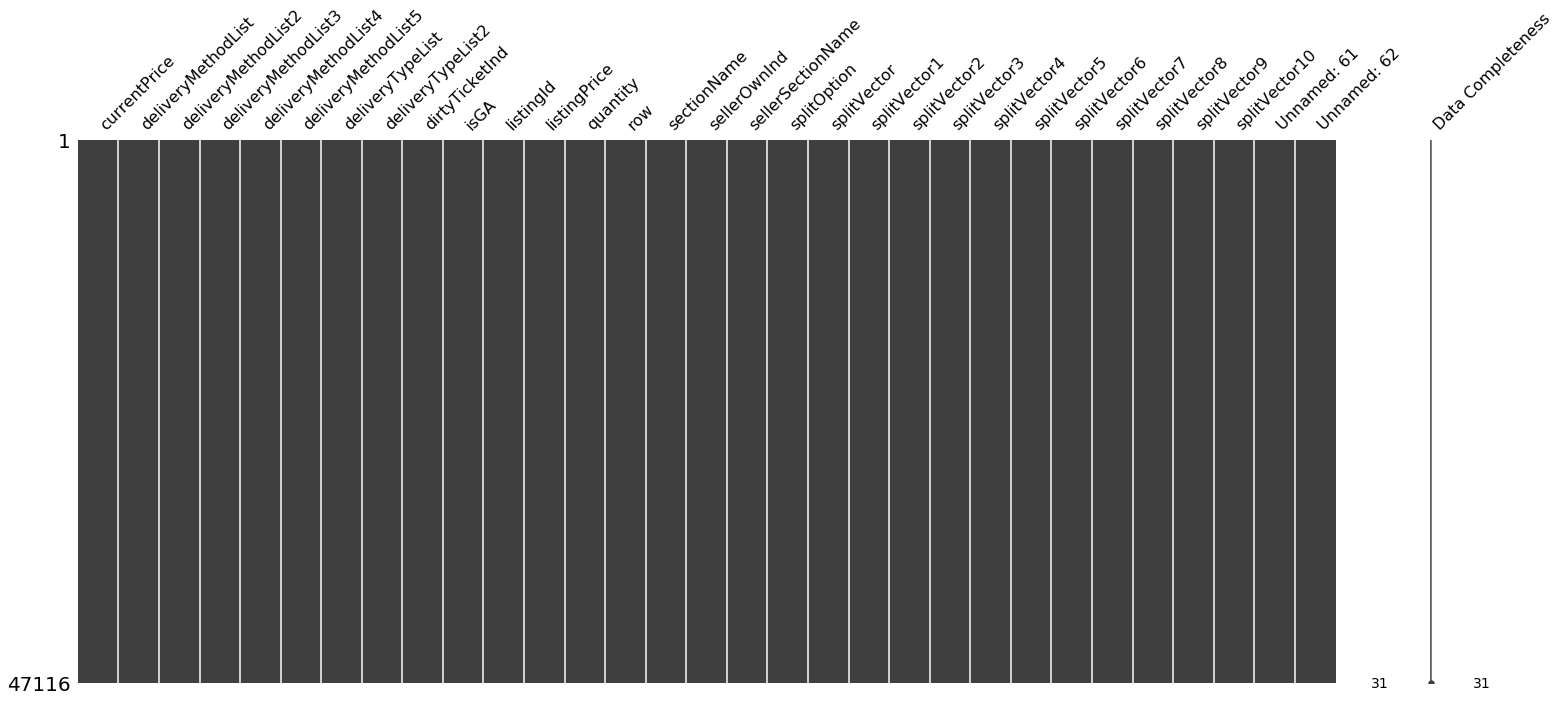

In [5]:
#The matrix shows which columns have missing data points
msno.matrix(dftot, labels=True, filter='top', sort='descending', n=31)

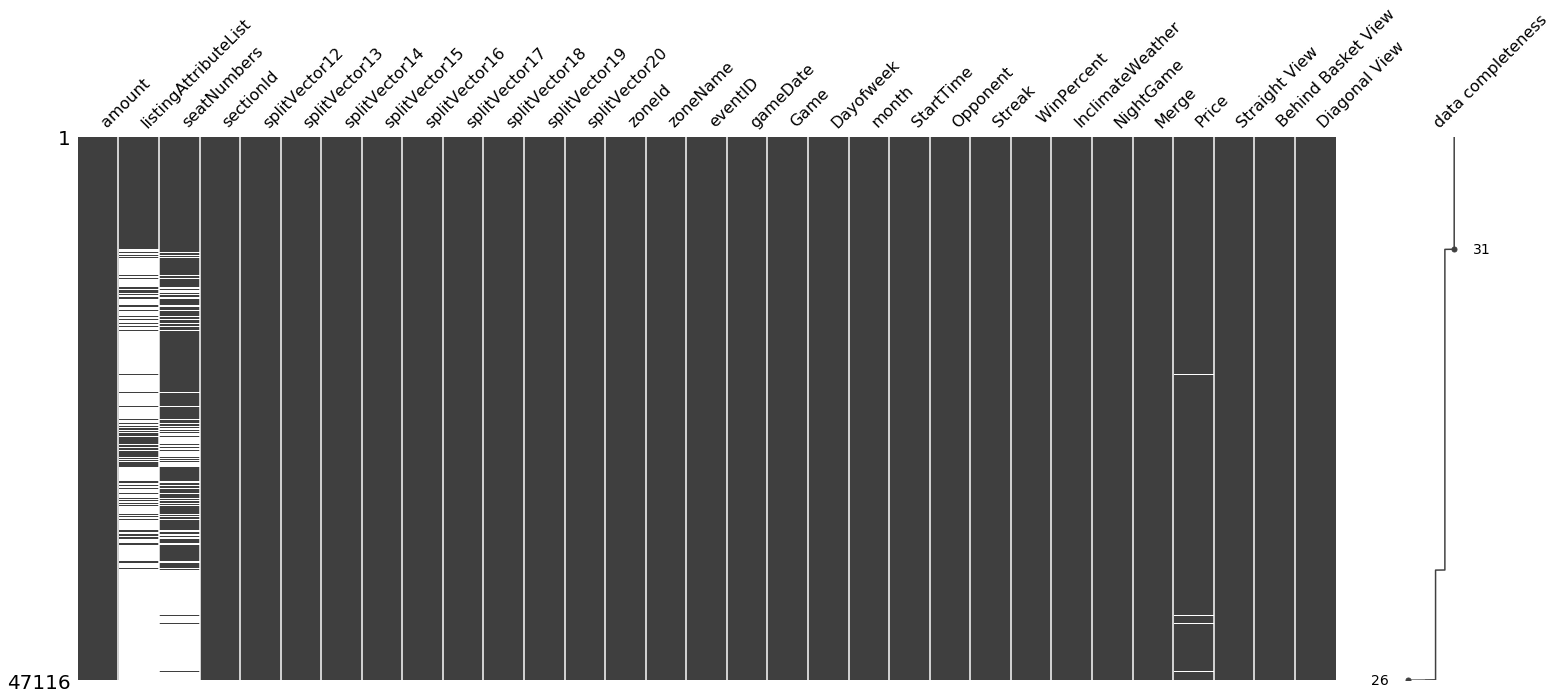

In [6]:
#The matrix shows which columns have missing data points
msno.matrix(dftot, labels=True, filter='bottom', sort='descending', n=31)

There are scarce missing values in the data set. The listingAttributeList, seatNumbers and Price columns are the only ones that have missing values. 

* Seat Numbers: The missing values should not be an issue because we are more concerned with section row than seat number. Prices are a function of section-row not seat number. 

* Listing Attributeid: This variable comes from the StubHub listings. Some listings have an id, others do not. We are aren't sure why; however, there does not seem to be any relationship between this variable and the resale price, the ticket quality or anything for that matter. It appears just to be a random id attributed to certain listings.

* Price: We will explore the NAN values for price in just a little bit. There are certain tickets that are not sold as season tickets. Since price measures the per game ticket price of a season ticket seat, seats that are not sold as season tickets will have NaN values

In [7]:
dftot.shape

(47116, 63)

We have data for 47,116 tickets being resold on Stubhub.com and 63 features. We are going to have to see which features are best suited to include in our model, and which features we should drop. Furthermore, we are going to have to decide what to do with NaN values in several columns and this will come with understanding what those NaN values truly mean

In [8]:
#The value on listing price and other columns is within a list. This code extracts the price from those lists
def extract_amount(df, col):
    li = []
    for x in df[col]:
        x = str(x)
        li.append(x[x.find(' '):x.find(',')].strip("\'"))
    li = [float(i) for i in li]
    df_data = pd.DataFrame(li, columns=[f'amount_{col}'])
    df_data = pd.concat([df, df_data], axis=1)
    
    return df_data
 

Here we will clean the listing price, current price, and face value columns then add them to our dataset. This will give us 28 features. The new column titles will add amount_ and currency_ to each new column.

In [9]:
#Extract the amount from each feature
dictcols = extract_amount(dftot, 'listingPrice')
dictcols = extract_amount(dictcols, 'currentPrice')

Below I created another matrix to see we need to clean the following columns:
  - seatNumbers
  - listingAttributeCategoryList
  - listingAttributeList
  - businessGuid

In [10]:
# #Drop columns that have been cleaned: listingPrice and currentPrice
dropped = dftot.drop(['currentPrice', 'eventID','dirtyTicketInd', 'listingId', 'sectionId', 'sellerOwnInd', 'sellerSectionName', 'zoneId', 'zoneName', 'listingAttributeList'], axis=1)
final = dropped

In [11]:
#So far we have decided to remove 13 columns from within the dataset because they are collinear with each other, other features that we kept, or the target feature that we are choosing to model on
final.shape

(47116, 53)

In [12]:
#nans are in season ticket price column because certain seats are not sold such as Courtside seats and select lower bowl seats
final.Price.unique()


array([  6.,  12.,  17.,  36.,  47.,  63.,  88.,  nan, 168., 138.,  26.,
       110.,  33.,  74., 148., 139.])

NaN prices in the Price column represent tickets that are not sold as season tickets. Since the premise of our model is to predict the margin between resale price of tickets and single game price of tickets. It does not make sense to include tickets that do not have a per game season ticket price. Thus we can drop NaNs

In [13]:
final = final[np.isfinite(final['Price'])]

In [14]:
final.Price.isna().sum()

0

# Prepping Categorical Variables

In [15]:
#Split the data into numerical and categorical sets
df_final = final
cat = df_final.select_dtypes(include = ['object'])
dog = df_final.select_dtypes(exclude = ['object'])

In [16]:
#Understand what kind of categorical data we are working with and if there are missing values
cat.describe()

,listingPrice,row,seatNumbers,gameDate,StartTime,Opponent,Merge,Unnamed: 61,Unnamed: 62
count,46898,46898,30760,46898,46898,46898,46898,46898,46898
unique,3358,29,237,64,7,30,767,1,1
top,"{'amount': 55.0, 'currency': 'USD'}",12,General Admission,11/9/18,9:00p,Golden State Warriors,107s12r,s,r
freq,517,4630,8378,1165,32038,3331,473,46898,46898


The Merge, Unamed 61 and Unamed 62 columns seem to be junk columns pulled into our data set. We can go ahead and delete these columns out as they should have no predictive qualities as features for our model.

In [17]:
df_final = df_final.drop(['Merge','Unnamed: 61', 'Unnamed: 62'],axis=1)

In [18]:
#Verify that we have removed those columns from the data set
df_final.shape

(46898, 50)

## Visualizations

Here we will visualize our target feature against some of the variables of interest to see how they relate to each other and also if there are any outliars or surprises that may need to be dealt with

In [19]:
#Create Feature that we want to model on
#Now we will check correlation with target variable
df_final['target_margin'] = df_final['amount']*.85 - df_final['Price']


We multiply the amount by .85 because stubhub takes 15% of the resale price. We assume that this markup raises the listing price and therefore are interest remains on the true margin between what the seller takes home and the original season ticket price per game for the ticket. 

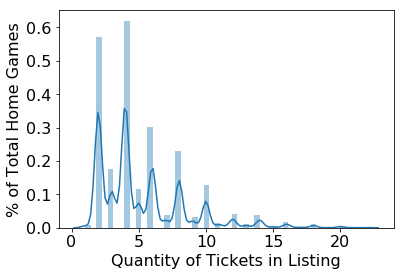

In [20]:
#Visualizing the distribution of listings' ticket quantity
#We are interested in seeing which quanities are most common and which ones are associated with higher resale prices
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
sns.distplot(df_final.quantity)
plt.xlabel("Quantity of Tickets in Listing", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("% of Total Home Games",fontsize=16)
rcParams['figure.figsize'] = 11.7,8.27

It is apparent that most listings are sold in quantities of two or four tickets, with six tickets being the next most frequently occurring. If one were looking to get into reselling season tickets, our hunch is that selling in pairs enables the seller to sell for a higher price. We will create a visualization below to see what the mean price is per quantity value to see if that holds true.

Text(0.5, 1.0, 'Resale Margin by Quantity of Tickets Packaged in Listing')

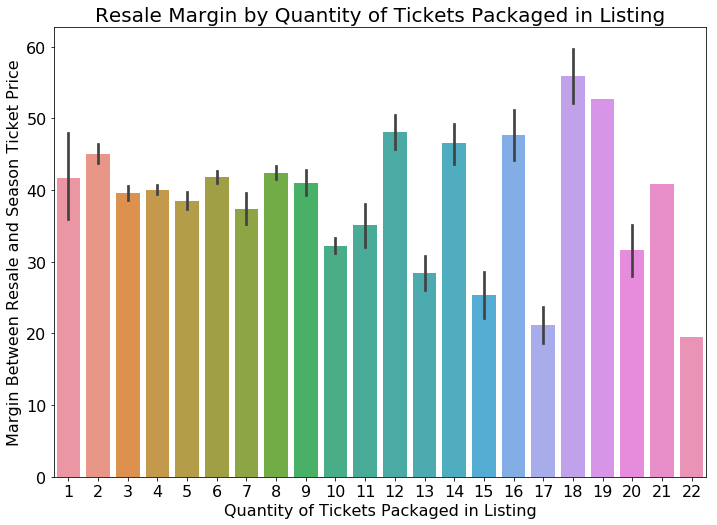

In [21]:
#Move this up a bit
sns.barplot(df_final.quantity, df_final.target_margin)
rcParams['figure.figsize'] = 11.7,8.27
plt.xlabel("Quantity of Tickets Packaged in Listing", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Margin Between Resale and Season Ticket Price",fontsize=16)
plt.title("Resale Margin by Quantity of Tickets Packaged in Listing", fontsize=20)

It seems to be pretty consistent across quantities. This would suggest that quantity amount is not very correlated with the resale margin. We will investigate that further later on when we plot the correlation maps

Text(0.5, 1.0, 'Distribution of Games by Winning Streak')

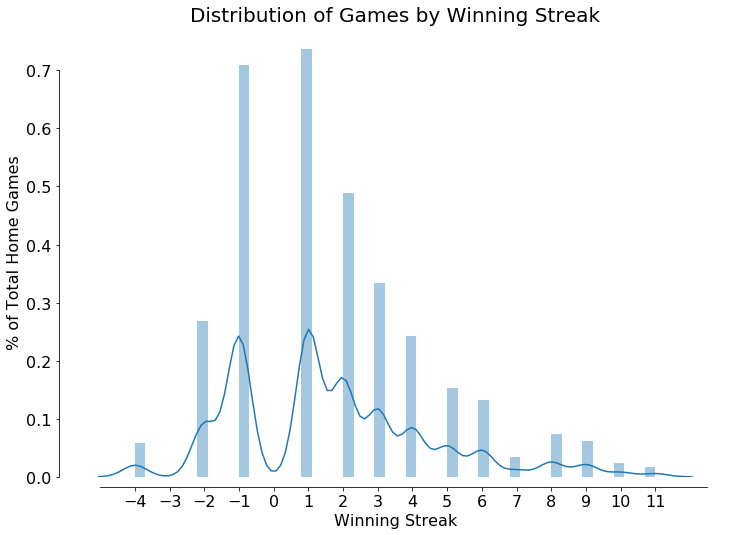

In [22]:
#Distribution of winning streak
#Do winning streaks spike up ticket prices? This distribution will help contextualize the visualization that follows
sns.distplot(df_final.Streak)
rcParams['figure.figsize'] = 11.7,8.27
sns.despine(offset=10, trim=True);
plt.xlabel("Winning Streak", fontsize=16)
plt.xticks(np.arange(min(df_final.Streak), max(df_final.Streak)+1, 1.0))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("% of Total Home Games",fontsize=16)
plt.title("Distribution of Games by Winning Streak", fontsize=20)

Within our 61 game sample, the Jazz have done pretty well. The large right tail indicates they are likely to be on a winning streak heading into a home game. This distribution will help our intepretation of the next figure.

Text(0.5, 1.0, 'Resale Margin By Winning Streak')

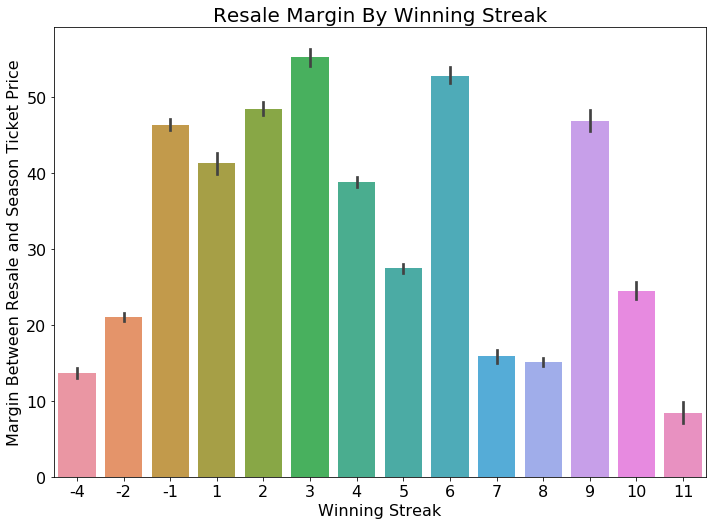

In [23]:
#Plot showing the mean resale margin by streak
sns.barplot(df_final.Streak, df_final.target_margin)
rcParams['figure.figsize'] = 11.7,8.27
plt.xlabel("Winning Streak", fontsize=16)
plt.ylabel("Margin Between Resale and Season Ticket Price",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Resale Margin By Winning Streak", fontsize=20)

The margin appears to be pretty consistent if the jazz are on a winning streak; however, it is interesting to note that the resale margin plummeted when the jazz were on a losing streak longer of 2 games or more. Part of that has to do with small sample size of such events and could be correlated with the teams they played while they were on those losing streaks. It is, however, interesting to see some negative effect that losing has on reselling tickets.

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday')]

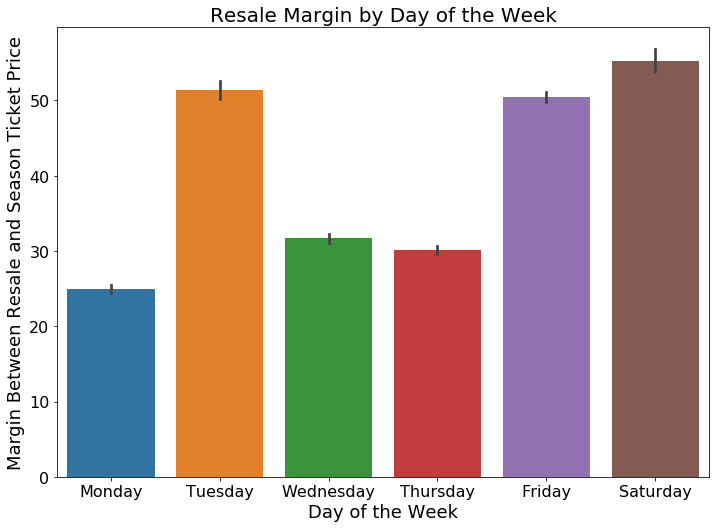

In [24]:
#This plot will show how day of the week and resale margin are related
ax = sns.barplot(df_final.Dayofweek, df_final.target_margin)
rcParams['figure.figsize'] = 11.7,8.27
plt.xlabel("Day of the Week", fontsize=18)
plt.ylabel("Margin Between Resale and Season Ticket Price",fontsize=18)
plt.title("Resale Margin by Day of the Week", fontsize=20)
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#Rename the columns from dummy values to day of the week
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
labels[5] = 'Saturday'
ax.set_xticklabels(labels)

Interestingly enough, the Jazz are the only team in the NBA that do not play home games on Sunday (I think we might know why... ) 

It is no surprise that weekend days - Friday and Saturday - have higher margins; however, it is surprising to see that Tuesday games seem to sell better than the other weekday counterparts. This will prompt a short investigation to see if there is an outliar or two in the tuesday data that is perhaps driving up the target margin. 

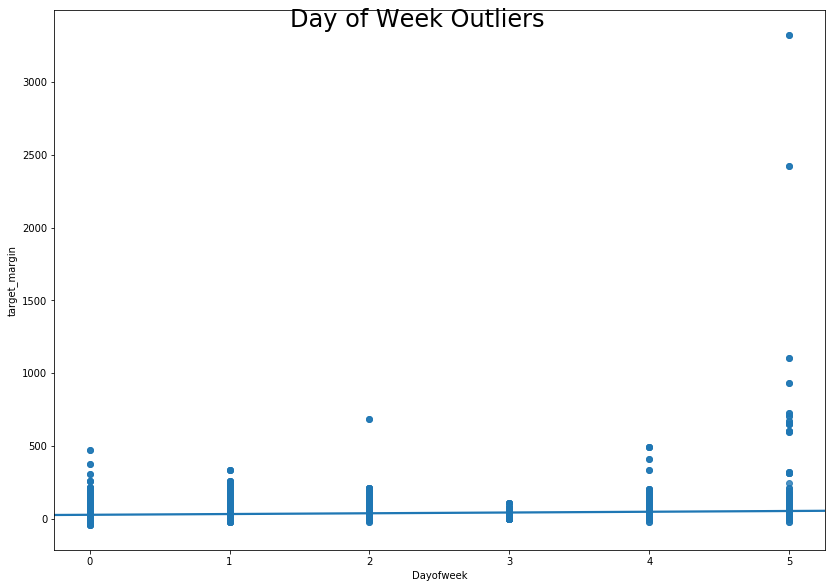

In [25]:
sns.regplot(x=df_final['Dayofweek'], y=df_final['target_margin'])
plt.tight_layout()    
plt.suptitle("Day of Week Outliers", fontsize = 24)
plt.show()

It appears as though there are some major outliers in the data that are affecting our Tuesday, Friday, and Saturday values. We are going to check to see if the insanely high margins correspond to sections that are higher priced to begin with. The only way this could possibly make sense is if the seats are high priced to begin with and the markup does not represent a huge % increase of the season ticket price for a given seat.

In [26]:
table = pd.pivot_table(df_final, values='target_margin', index=['sectionName'], columns=['Dayofweek'], aggfunc=np.max)

In [27]:
table

Dayofweek,0,1,2,3,4,5
sectionName,,,,,,
1,147.2050,193.1050,131.9050,56.9010,128.3050,3323.9650
2,68.3025,187.9250,167.5250,36.0250,159.3515,97.0280
3,219.2115,143.1165,123.4250,56.1050,8.6975,118.4865
4,60.5050,224.7250,132.6435,38.4135,140.4210,84.7120
5,29.0940,53.2850,NaN,NaN,70.9670,NaN
6,168.1050,56.9165,171.5220,5.0070,168.1050,601.8090
7,259.1890,335.8250,102.6860,NaN,198.1250,709.6625
8,177.6250,249.7050,684.2050,55.9050,174.6650,66.1050
9,NaN,NaN,88.5450,NaN,37.8340,75.7080


There are clear outliers that we will need to remove from the data. Any margin in the thousands is not indicative of the actual resale value of the tickets. Especially considering we removed playoff games from the data.

Also, of note: the max values for Tuesday seem to be high. We have a hunch that there could be an outlier game that was played on a Tuesday that is driving the mean value of tuesday margins up. The means were shown in the seaborn plot a few lines up and tuesday is inconsistent with other weekdays. Intuitively approaching the issue, there has to be something driving this difference other than the inherent value of attending a game on a Tuesday.

In [28]:
#Let's drop those absurdly high markup values and chalk them up to a mistake in the system
df_final = df_final.drop(df_final[(df_final['amount']>900)].index)

In [29]:
#Let's see who the Jazz have played on Tuesdays in our 61 game sample
Tuesday = df_final['Dayofweek'] == 1
RubyTuesday = df_final[Tuesday]
RubyTuesday.Opponent.unique()

array(['Golden State Warriors', 'Detroit Pistons', 'Atlanta Hawks',
       'Los Angeles Lakers', 'San Antonio Spurs',
       'Portland Trail Blazers'], dtype=object)

In [30]:
#Perhaps there are some dates of note that might have driven the prices up
RubyTuesday.gameDate.unique()

array(['1/30/18', '3/13/18', '3/20/18', '4/3/18', '4/10/18', '12/4/18',
       '12/25/18'], dtype=object)

This makes manifest why the mean markup prices on Tuesdays seem to be so much higher than the other days. Later on in the model we discover that playing both the Golden State Warriors and the Los Angeles Lakers to be big drivers of higher margins. This makes sense - fans want to see the big market teams (Lakers) and once-in-a-generation talented Warriors team.

Furthermore, there are only 7 games played on Tuesdays in the sample of 61 home games. With two against big market teams and then another falling on Christmas day against the Portland Trail Blazers on ESPN, it is no surprise. Christmas day games are notoriously expensive. 

While Tuesdays appear to be an outlier, at least there are logical reasons to explain why they are. There is no good reason to eliminate certain games from the data, so we will continue forward.

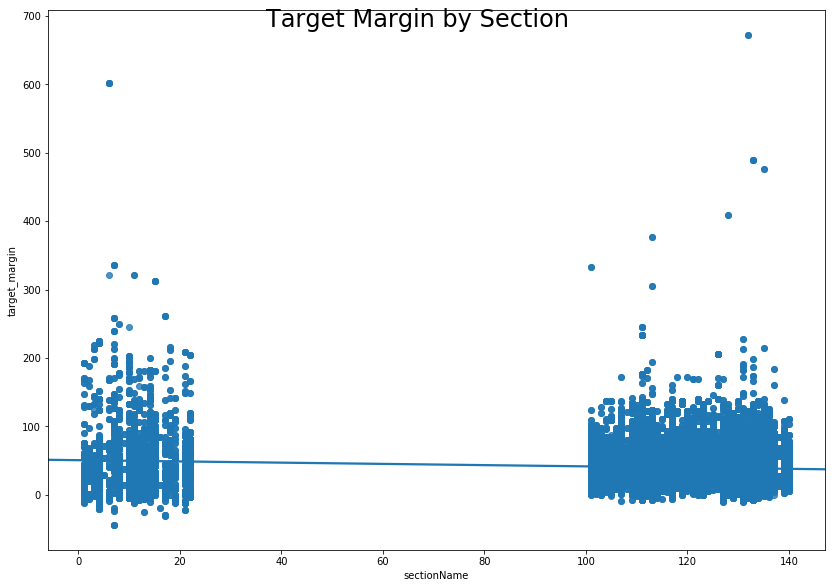

In [31]:
#Examining section number and resale price
sns.regplot(x=df_final['sectionName'], y=df_final['target_margin'])
plt.tight_layout()    
plt.suptitle("Target Margin by Section", fontsize = 24)
plt.show()

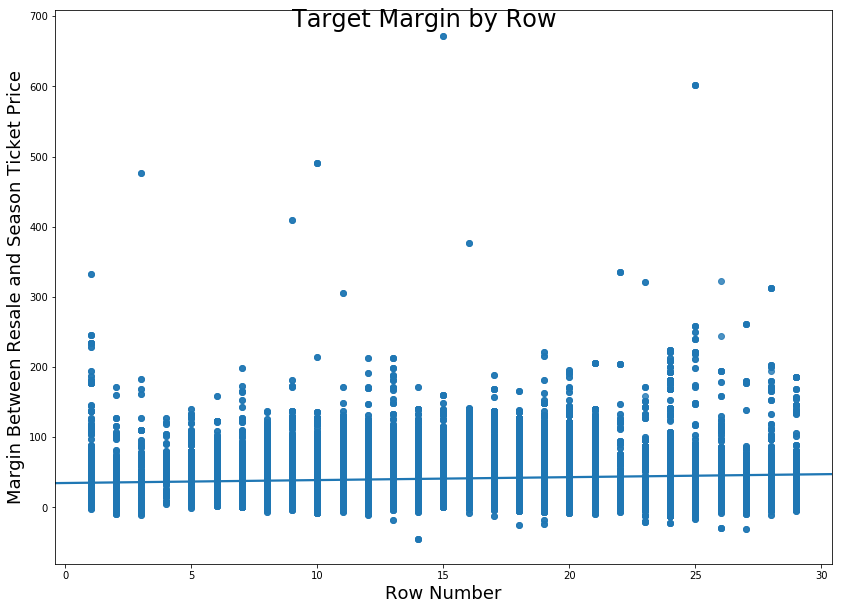

In [32]:
#Examining row number and resale price
row = np.array(df_final['row'], dtype=int)
sns.regplot(x=row, y=df_final['target_margin'])
plt.tight_layout()    
plt.suptitle("Target Margin by Row", fontsize = 24)
plt.xlabel("Row Number", fontsize=18)
plt.ylabel("Margin Between Resale and Season Ticket Price",fontsize=18)
plt.show()

We are faced with an interesting problem. The Target Margin variable is derived from the amount the ticket resold for and the season ticket per game price. The per game price is set as a function of section and row number. The season ticket prices are allotted in several different groups in each section. For example, one section might have 5 different pricing options spread out between rows 1-25. This means target_margin should be similar for tickets in like groupings.

In order to eliminate outliers, we have to first pair the section and row together in order to see where we are seeing values that do not belong with the typical values in their respective grouping. To do this, we will create a 3d plot that pairs all three of those dimensions: row, section, and target_margin.

TypeError: view_init() takes from 1 to 3 positional arguments but 4 were given

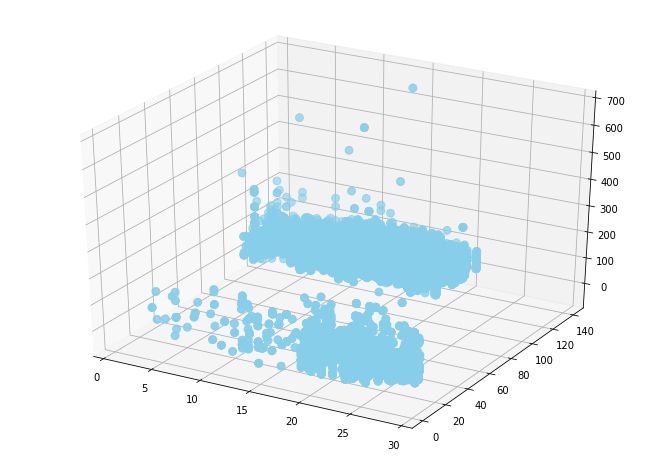

In [33]:
#Import module to create 3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(row, df_final['sectionName'], df_final['target_margin'], c='skyblue', s=60)
ax.view_init(60, 210, 20)
plt.show()


In the interactive online mode we were able to play around with this 3d scatter plot to find outliers that do not seem to make much sense given their section-row combination. Given that season ticket pricing is factored by row - section, we needed to use this look to correctly identify outliers. Nominal jumps weren't enough because the target margin should factor in section - row as it is a function of season ticket price and listing price.

With this helpful information, we are able to drop certain outliers from the model and continue cleaning.

In [34]:
#The row column being a string is causing some issues
df_final.row.unique()

array(['21', '19', '20', '16', '17', '15', '13', '4', '18', '10', '14',
       '11', '7', '12', '3', '26', '28', '23', '25', '8', '9', '5', '6',
       '24', '22', '2', '1', '29', '27'], dtype=object)

In [35]:
#Used to transform the rows from a string into an integer
def rows(x):
    if x == '21':
        return 21
    if x == '19':
        return 19
    if x == '20':
        return 20
    if x == '16':
        return 16
    if x == '17':
        return 17
    if x == '15':
        return 15
    if x =='13':
        return 13
    if x == '4':
        return 4
    if x == '18':
        return 18
    if x == '10':
        return 10
    if x == '14':
        return 14
    if x == '11':
        return 11
    if x == '7':
        return 7
    if x =='12':
        return 12
    if x =='3':
        return 3
    if x =='26':
        return 26
    if x == '28':
        return 28
    if x == '23':
        return 23
    if x == '25':
        return 25
    if x == '8':
        return 8
    if x == '9':
        return 9
    if x == '5':
        return 5
    if x == '6':
        return 6
    if x == '24':
        return 24
    if x == '22':
        return 22
    if x == '2':
        return 2
    if x == '1':
        return 1 
    if x == '29':
        return 29
    if x == '27':
        return 27
    

In [36]:
#Apply the transformation
df_final['rows'] = df_final['row'].apply(rows)

In [37]:
#Drop the outliers based off of the 3D scatterplot
df_final = df_final.drop(df_final[(df_final['sectionName']>100)
                                  & (df_final['target_margin']>300)].index)
df_final = df_final.drop(df_final[(df_final['rows']>20)
                                  & (df_final['target_margin']>300)].index)
df_final = df_final.drop(df_final[(df_final['rows']==16)
                                  & (df_final['target_margin']>300)].index)
df_final = df_final.drop(df_final[(df_final['rows']==22)
                                  & (df_final['target_margin']>300)].index)
df_final = df_final.drop(df_final[(df_final['amount']>2000)].index)
df_final = df_final.drop(df_final[(df_final['amount']>500) & (df_final['Price']<40)].index)

Now we have succesfully dropped outliers that we found by visualizing our data. This will help prevent against overfitting when it comes time to train our models.

In [38]:
#Drop the old row column
df_final = df_final.drop(['row'], axis=1)

Text(0.5, 1.0, 'Mean Resale Margin by Section Number')

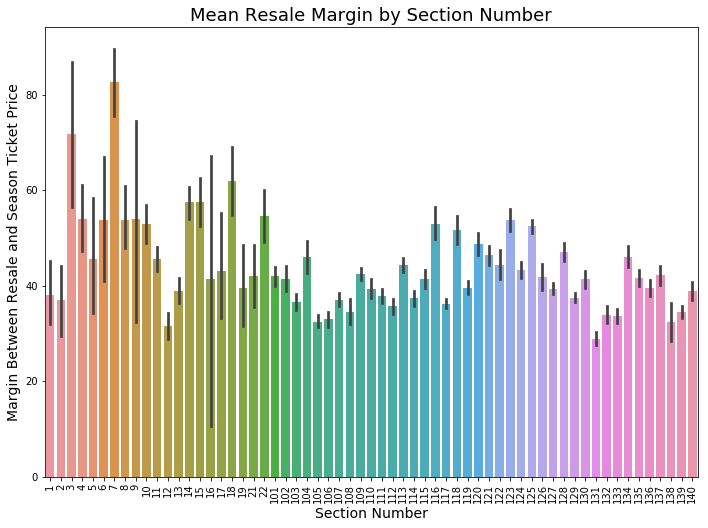

In [39]:
#Our final visualization, resale margin by section number
sns.barplot(df_final.sectionName, df_final.target_margin)
plt.xticks(rotation=90)
rcParams['figure.figsize'] = 22,16
plt.xlabel("Section Number", fontsize=14)
plt.ylabel("Margin Between Resale and Season Ticket Price",fontsize=14)
plt.title("Mean Resale Margin by Section Number", fontsize=18)

This appears to make intuitive sense. Single and Double Digit sections are in the lower bowl. These sections should have higher nominal margins because their price is higher. From an overarching perspective, the percent return on the investment should be similar in both the lower and upper bowl 

In [40]:
#Check other features for outliers or values that do not belong
df_final.StartTime.unique()

array(['8:00p', '9:00p', '10:30p', '9:30p', '10:00p', '5:00p', '9'],
      dtype=object)

In [41]:
#This is probably not the most time effective, but it still works at converting the 9 to the value we want
def StartTimes(x):
    if x == '9':
        return '9:00p'
    if x == '8:00p':
        return '8:00p'
    if x == '9:00p':
        return "9:00p"
    if x == '10:30p':
        return '10:30p'
    if x == '9:30p':
        return '9:30p'
    if x == '10:00p':
        return '10:00p'
    if x == '5:00p':
        return '5:00p'

In [42]:
#Apply the transformation
df_final['StartTimes'] = df_final['StartTime'].apply(StartTimes)

In [43]:
#Drop the old column and keep the new, correct one
df_final = df_final.drop(['StartTime'], axis=1)

## Correlation

In [44]:
#Check the correlation of the variables with each other and with the target feature
corr = df_final.corr()

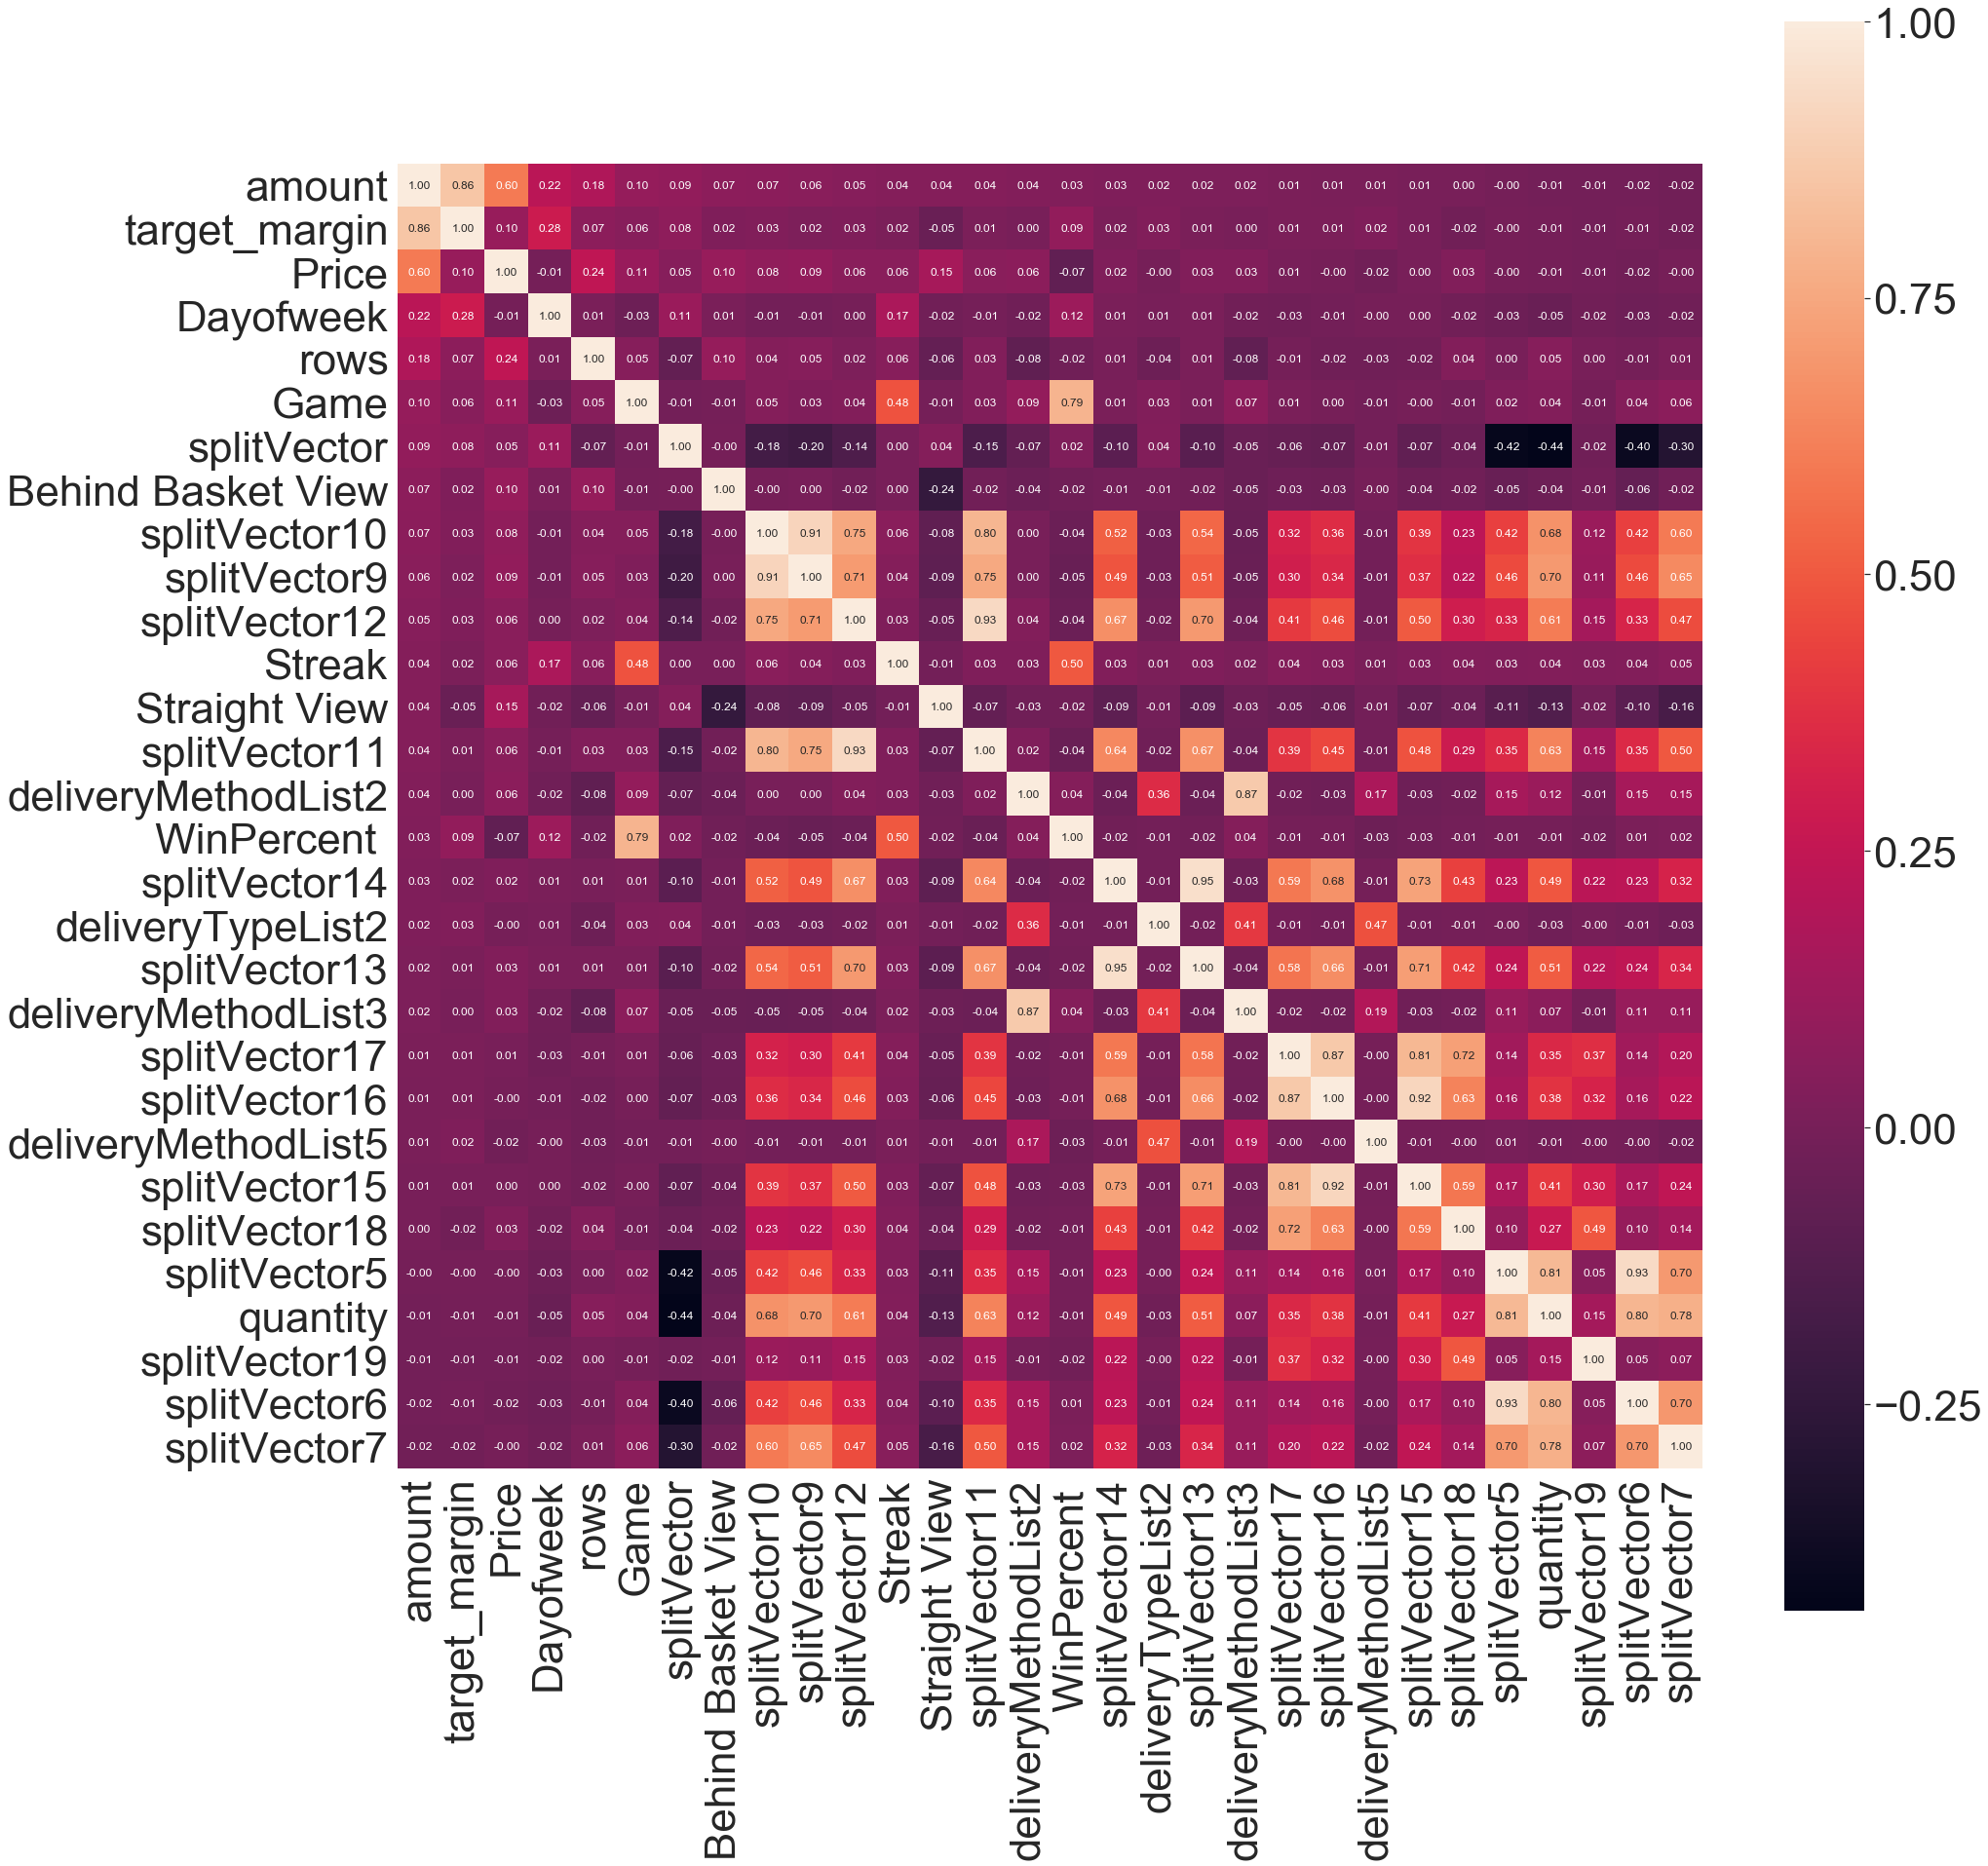

In [45]:
k =30
cols = corr.nlargest(k, 'amount')['sectionName'].index
cm = np.corrcoef(df_final[cols].values.T)
sns.set(font_scale=4)
f, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The initial looks shows that target margin is highly correlated with the price and the amount. That is how it should be because it is literally calculated using those two features. We will drop those in a second because those two seem to drown out a lot of the correlation. That should help to see which features are most helpful in predicting the target margin.

Additionally. We can see that the split vector columns almost have zero effect on target_margin. The Split vectors are highly correlated with quantity because the listing can be split into many different vectors as the quantity increases. Because the effect is captured already in quantity and given the redundancy of these columns, it is safe to assume that we can drop them from the model.

Finally, we will remove some of the deliveryMethodList columns as they are inconsequential in our model.

In [46]:
#Because splitvector columns are highly correlated with quantity, we can remove those columns out for modeling purposes
df_final = df_final.drop(['splitVector', 'splitVector2', 'splitVector3', 'splitVector4', 'splitVector5','splitVector6',
                        'splitVector7', 'splitVector8', 'splitVector9', 'splitVector10', 'splitVector11',
                        'splitVector12', 'splitVector13','splitVector14', 'splitVector15', 'splitVector16',
                        'splitVector17', 'splitVector18', 'splitVector19', 'splitVector20'],axis=1)

In [47]:
#Drop some of the deliveryMethodList variables
df_final = df_final.drop(['deliveryMethodList2', 'deliveryMethodList3',
                         'deliveryMethodList4', 'deliveryMethodList5', 'deliveryMethodList'],axis=1)

In [48]:
#Let's drop all correlated price related columns as well
df_final = df_final.drop(['amount', 'Price', 'listingPrice'], axis=1)

In [49]:
df_final.columns

Index(['deliveryTypeList', 'deliveryTypeList2', 'isGA', 'quantity',
       'seatNumbers', 'sectionName', 'splitOption', 'splitVector1', 'gameDate',
       'Game', 'Dayofweek', 'month', 'Opponent', 'Streak', ' WinPercent ',
       'InclimateWeather', 'NightGame', 'Straight View', 'Behind Basket View',
       'Diagonal View', 'target_margin', 'rows', 'StartTimes'],
      dtype='object')

In [50]:
corr = df_final.corr()

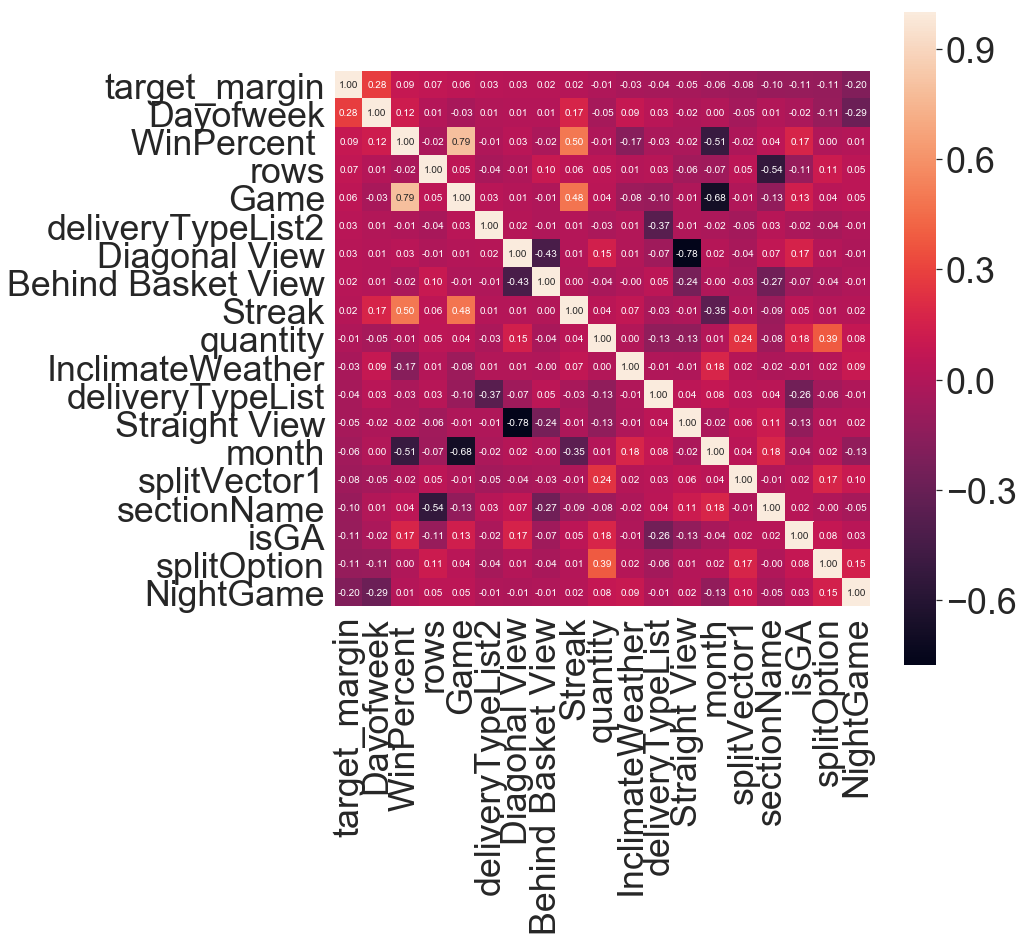

In [51]:
k =30
cols = corr.nlargest(k, 'target_margin')['target_margin'].index
cm = np.corrcoef(df_final[cols].values.T)
sns.set(font_scale=3.25)
f, ax = plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Now it appears that we have a cleaner set of features, most have a pretty small correlation with target_margin; however, they make intuitive sense. For example SectionName is negatively correlated with target_margin. Because target margin is in nominal terms, as section number increases the nominal margin of resale should decrease because the tickets are inherently cheaper.

In [52]:
#Create Dummy variables for team names and other like variables
df_final = pd.get_dummies(df_final)

In [53]:
df_final.shape

(46846, 356)

In [54]:
#defining the target variable for the train test split
y = df_final['target_margin']
X = df_final.drop(['target_margin'], axis=1)

# Modeling

To begin modeling we will split and scale the data. We want to look at 3 different regression techniques to understand predict margin price. We will look at the following models and hyperparameters.

* Stochastic Gradient Descent Regressor
    - eta0
* RandomForest Regressor
    - n_estimators
    - max_depth
* Gradient Boosting Regressor
    - n_estimators
    - max_depth
    - learning_rate

After tuning each hyperparameter with a gridsearch technique we looked as root mean squared error to evaluate each model. 

In [55]:
#Import modules
from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [56]:
#Splitting the data into test and train data sets
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(37476, 355) (37476,)
(9370, 355) (9370,)


In [57]:
#Use fit operation to fit the x_train data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sclr = StandardScaler()
sclr.fit(X_train)
X_scale = sclr.transform(X_train)
X_scale_test = sclr.transform(X_test)

# SGD Regressor

The SGD Regressor is a stochastic gradient descent regression that uses a loss function to calculate.

In [59]:
%%time 
lin_reg_model = SGDRegressor()
#This is the learning rate at the outset
parametersearch = {"eta0": [.0005], 
                   "learning_rate": ['adaptive', 'invscaling'], 
                   "loss": ['epsilon_insensitive', 'squared_loss', 'huber'], 
                   "penalty": ['elasticnet', 'l1', 'l2']}
                            #.001, .003, .01, .03, .05, .07, .1, .15, .2, .3, 1]}
#used to find the best parameters for our model
gridsearch = GridSearchCV(lin_reg_model,param_grid=parametersearch, cv=3, scoring='neg_mean_squared_error')
gridsearch.fit(X_scale,y_train)
print("Ideal Parameters: {}".format(gridsearch.best_params_))

Ideal Parameters: {'eta0': 0.0005, 'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'elasticnet'}
CPU times: user 18.3 s, sys: 1.31 s, total: 19.6 s
Wall time: 18.5 s


In [60]:
#Run the model with the tuned parameters
lin_reg_model = SGDRegressor(eta0=.0005, learning_rate='invscaling', loss='squared_loss', penalty='l2')
lin_reg_model.fit(X_scale, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [61]:
%%time 

#predicts values on train and test for the fitted model
tr_pre = lin_reg_model.predict(X_scale)
te_pre = lin_reg_model.predict(X_scale_test)

#Calculates Root Predicted Mean Squared Error
train_RMSE_sgd = np.sqrt(mean_squared_error(y_train, tr_pre))
test_RMSE_sgd = np.sqrt(mean_squared_error(y_test, te_pre))

#Shows our RMSE 
print("Train RMSE: {}".format(train_RMSE_sgd))
print("Test RMSE: {}".format(test_RMSE_sgd))

Train RMSE: 17.605370012309873
Test RMSE: 17.23555443205488
CPU times: user 20.5 ms, sys: 2.59 ms, total: 23.1 ms
Wall time: 16.6 ms


# RandomForest Regressor

In [62]:
%%time

#Run a Gridsearch to determine the best hyperparameters. We will look at the following:
# max_depth: 13
# n_estimators: 500

fore = RandomForestRegressor()
for_params = {"n_estimators": [500], "max_depth": [13]}
              #[100,500,750], "max_depth": [3,5,8,12,13]}
gridsearch3 = GridSearchCV(fore,param_grid=for_params, cv=3, scoring='neg_mean_squared_error')
gridsearch3.fit(X_train,y_train)
print("Ideal Parameters: {}".format(gridsearch3.best_params_))


Ideal Parameters: {'max_depth': 13, 'n_estimators': 500}
CPU times: user 6min 16s, sys: 2.1 s, total: 6min 18s
Wall time: 6min 43s


In [63]:
%%time

#Fit the model
model_rf = RandomForestRegressor(n_estimators=500, max_depth=13)
model_rf.fit(X_train, y_train)

CPU times: user 2min 18s, sys: 1.15 s, total: 2min 19s
Wall time: 2min 36s


In [64]:
%%time

#predicts values on train and test for the fitted model
tr_pre = model_rf.predict(X_train)
te_pre = model_rf.predict(X_test)

#Calculates Root Predicted Mean Squared Error
train_RMSE_rf = np.sqrt(mean_squared_error(y_train, tr_pre))
test_RMSE_rf = np.sqrt(mean_squared_error(y_test, te_pre))

#Shows our RMSE 
print("Train RMSE: {}".format(train_RMSE_rf))
print("Test RMSE: {}".format(test_RMSE_rf))

Train RMSE: 10.653733857936645
Test RMSE: 11.094063541404608
CPU times: user 2.6 s, sys: 67.4 ms, total: 2.66 s
Wall time: 2.69 s


Now that we have run the gridsearch the tuned parameters use 500 estimators and a max depth of 13. With the RandomForest we are slightly overfitting. The RMSE for the train data is 10.65 which is much larger than the RMSE for the test data at 11.09. We will now fit the model

# Gradient Boosting Regressor

In [67]:
%%time

#Calculates Root Mean Squared Error
train_RMSE_gb = np.sqrt(mean_squared_error(y_train, gb_train_predictions))
test_RMSE_gb = np.sqrt(mean_squared_error(y_test, gb_test_predictions))


#Shows our RMSE 
print("Train RMSE: {}".format(train_RMSE_gb))
print("Test RMSE: {}".format(test_RMSE_gb))

Train RMSE: 24.08534049181074
Test RMSE: 23.743396648907563
CPU times: user 2.03 ms, sys: 1.12 ms, total: 3.15 ms
Wall time: 1.94 ms


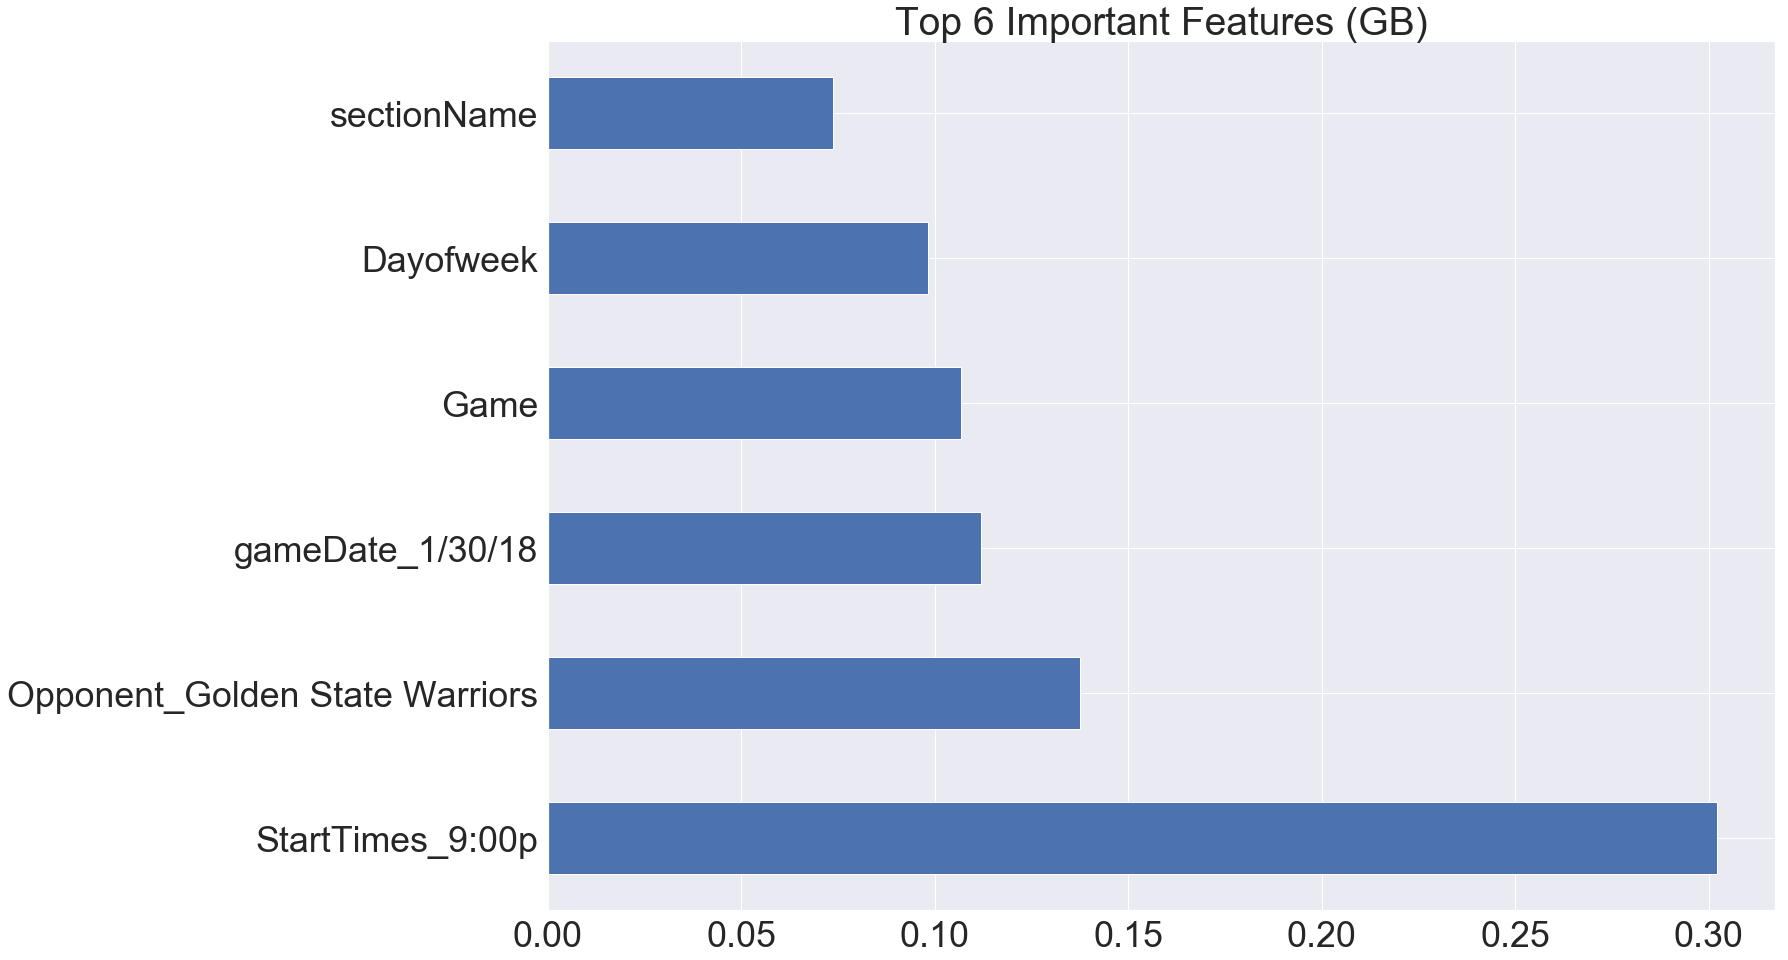

In [68]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(6).plot(kind='barh', title='Top 6 Important Features (GB)')

By looking at the relative feature weights we can see that the margin price is greatest when played at 9:00pm ET, Game Number is higher, the day of the week, and section name. The RMSE for this model is $24 so we will try another model to see if we can improve our predictions.

# XGBoost Regressor

In [58]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Here we use a gridsearch to optimize our XGBoost model. We look at the learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, and n_estimators.

In [ ]:
%%time
model = XGBRegressor(objective='reg:linear', colsample_bytree=.7, learning_rate=.45, max_depth=5, 
                     min_child_weight=3, n_estimators=5000, nthread=4, subsample=.7)

#model.fit(X_scale, y_train, eval)

model.fit(X_train, y_train, eval_metric='rmse', verbose = False, eval_set = [(X_test, y_test)])

# calculate the auc score
preds = model.predict(X_test)

print('\nRoot Mean Square error" ', np.sqrt(mean_squared_error(y_test,preds)))

In [ ]:
test_RMSE_xgb_tuned = np.sqrt(mean_squared_error(y_test,preds))

In [ ]:
#Plot all four RMSE's from each model
##THIS IS A COMPARISON OF EACH MODEL
df = pd.DataFrame({
    'Factor': ['SGD', 'RF', 'GB', 'XGB'],
    'Test RMSE': [test_RMSE_sgd, test_RMSE_rf, test_RMSE_gb, test_RMSE_xgb_tuned]
})
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = (
    df.set_index('Factor')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)
sns.barplot(x='Factor', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

# Conclusion

Of all the models that we ran, the XGboost was the closest. It got an RMSE that would suggest the resale margin within 18$. That model is not extremely effective, but unfortunately the features that we acquired and the sample size might have prevented the models from being as effective as they could have been.

Furthermore, the major caveat with this data is that there are some tickets that do not resell. We have a hard time identifying which tickets did not sell which causes issues when interepretting the results. One should be able to make a good resale margin on certain games when the tickets sell; however, that margin might be more than negatively compensated for when one factors in lower demand games that the tickets to not resell for. Generally speaking the demand for Jazz tickets is pretty high so if one is vigilant in placing tickets up for sale early at reasonable markup prices, they should be able to see some profitablity.

This leaves Scott's question somewhat unanswered as there is still some more work left to be done: which section-row has the best resale potential. Our model could not pinpoint that but rather predict the resale margin generally speaking as it refers to all of the tickets sold. 

In this kernel, the XGBoost did not run because of issues on my mac. If you check our powerpoint, you can see Josh's results from the XGBoost on the notebook that he ran. Unfortunately we made some aesthetic changes and added in a little more code in this notebook and were unable to combine the two. 

